In [1]:
%load_ext autotime
%matplotlib inline
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')

In [2]:
import py_entitymatching as em
import py_stringsimjoin as ssj
import profiler
import pandas as pd
import qgrid

time: 1.93 s


In [3]:
A = em.read_csv_metadata('./ORIG_DBLP_ACM/dblp_mur_clean.csv', key='id')
B = em.read_csv_metadata('./ORIG_DBLP_ACM/acm_mur_clean.csv', key='id')

time: 35.5 ms


In [4]:
A.head(2)

,id,title,authors,venue,year
0,conf/sigmod/RamaswamyK95,OODB Indexing by Class-Division,"Sridhar Ramaswamy, Paris C. Kanellakis",SIGMOD Conference,1995
1,journals/sigmod/GottlobKP03a,XPath processing in a nutshell,"Reinhard Pichler, Christoph Koch, Georg Gottlob",SIGMOD Record,2003


time: 13.9 ms


In [5]:
B.head(2)

,id,title,authors,venue,year
0,245896,Pixel-oriented database visualizations,Daniel A. Keim,ACM SIGMOD Record,1996
1,672175,Storage and Querying of E-Commerce Data,"Rakesh Agrawal, Amit Somani, Yirong Xu",Very Large Data Bases,2001


time: 8.4 ms


In [6]:
len(A), len(B)

(1979, 1991)

time: 2.45 ms


In [7]:
A1, B1 = em.down_sample(A, B, 300, 1, show_progress=False)
len(A1), len(B1)

(291, 300)

time: 388 ms


In [10]:
# Blocking

time: 689 µs


Number of unique values: 5
Number of missing values: 0

Unique values: 
['ACM Trans. Database Syst.', 'SIGMOD Conference', 'SIGMOD Record', 'VLDB', 'VLDB J.']

Frequency plot:



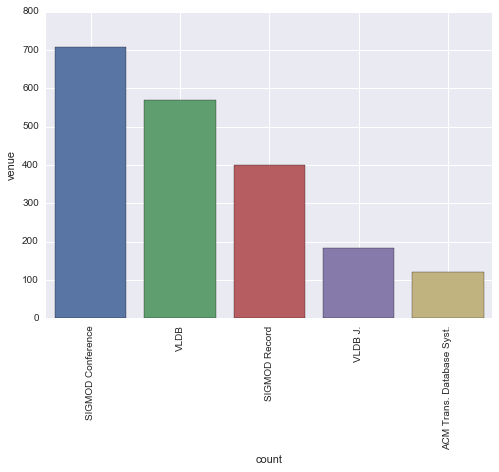

time: 226 ms


In [13]:
profiler.profile_table(A, 'venue')

Number of unique values: 5
Number of missing values: 0

Unique values: 
['ACM SIGMOD Record', 'ACM Transactions on Database Systems (TODS)', 'International Conference on Management of Data', 'The VLDB Journal — The International Journal on Very Large Data Bases', 'Very Large Data Bases']

Frequency plot:



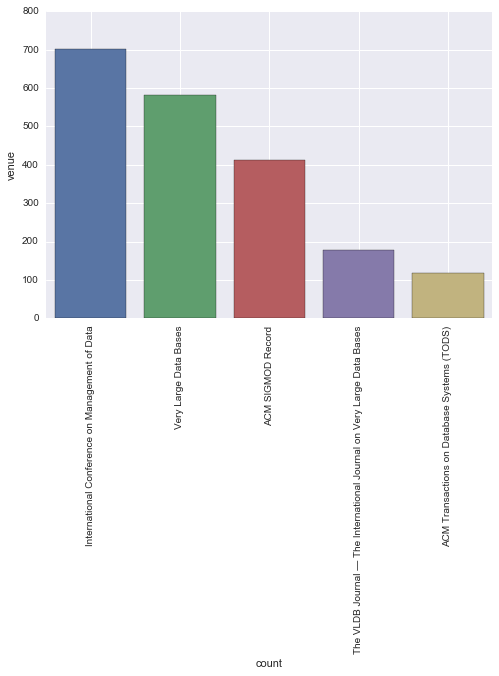

time: 255 ms


In [14]:
profiler.profile_table(B, 'venue')

Number of unique values: 10
Number of missing values: 0

Unique values: 
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



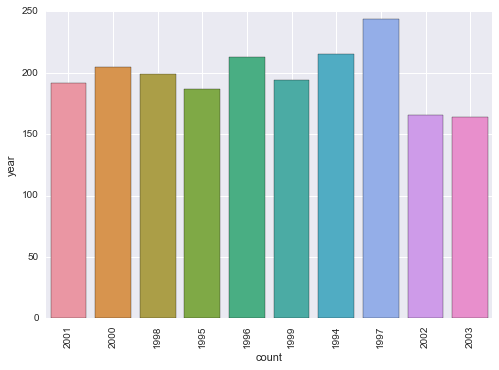

time: 361 ms


In [11]:
profiler.profile_table(A, 'year')

Number of unique values: 10
Number of missing values: 0

Unique values: 
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



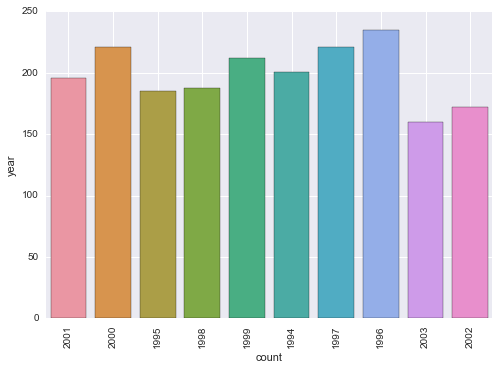

time: 238 ms


In [12]:
profiler.profile_table(B, 'year')

In [15]:
# Plan
### Plan

### A, B -- AttrEquivalnce blocker [year]--------------------------| Candidate set

time: 814 µs


In [16]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )

time: 167 ms


In [17]:
C1.head(2)

,_id,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year
0,0,conf/sigmod/RamaswamyK95,223898,OODB Indexing by Class-Division,"Sridhar Ramaswamy, Paris C. Kanellakis",1995,Paradise: a database system for GIS applications,CORPORATE The Paradise Team,1995
1,1,conf/sigmod/RamaswamyK95,210202,OODB Indexing by Class-Division,"Sridhar Ramaswamy, Paris C. Kanellakis",1995,Fast algorithms for universal quantification in large databases,"Goetz Graefe, Richard L. Cole",1995


time: 11.6 ms


In [19]:
# Debug blocking output

# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B, output_size=30)

time: 1.23 s


In [20]:
em.view_table(dbg)

time: 1min 58s


In [21]:
# Revised blocking plan

# A, B -- AttrEquivalnce blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

time: 918 µs


In [25]:
profiler.profile_table(A, 'title')

Number of unique values: 1970
Number of missing values: 0
time: 5.82 ms


In [23]:
profiler.profile_table(B, 'title')

Number of unique values: 1978
Number of missing values: 0
time: 5.88 ms


In [26]:
ob = em.OverlapBlocker()
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1)

time: 1.47 s


In [27]:
C = em.combine_blocker_outputs_via_union([C1, C2])

time: 1.28 s


In [28]:
# debug blocker
# check again with the updated blocking pipleline
dbg = em.debug_blocker(C, A, B, output_size=50)

time: 2.29 s


In [31]:
em.set_ltable(dbg, A)
em.set_rtable(dbg, B)
dbg = em.add_output_attributes(dbg, l_output_attrs=['year'], r_output_attrs=['year'], delete_from_catalog=False)

time: 12.4 ms


In [32]:
em.view_table(dbg)

time: 3min 38s


In [ ]:
# Sampling and labeling

In [34]:
# Sample candidate set
S = em.sample_table(C, 450)

time: 309 ms


In [35]:
# Label S
L = em.label_table(S, 'gold')

time: 5.18 s


In [45]:
# Use pre-labeled data
L = em.read_csv_metadata('./ORIG_DBLP_ACM/dblp_acm_demo_labels_clean.csv', ltable=A, rtable=B)

time: 6.82 ms


In [46]:
l_list_vals, r_list_vals = list(A.id.values), list(B.id.values)
prune_list_a = []
prune_list_b = []
count = 0
for row in L.itertuples(index=False):
    l_val, r_val = row[1], row[2]
    if l_val not in l_list_vals:
        prune_list_a.append(l_val)
    if r_val not in r_list_vals:
        prune_list_b.append(r_val)
    if l_val in l_list_vals and r_val in r_list_vals:
        count += 1
print(count)
        
    

310
time: 46.2 ms


In [50]:
gold = em.read_csv_metadata('./ORIG_DBLP_ACM/goldWithLabel.csv', key="_id")

time: 7.29 ms


In [51]:
l_list_vals, r_list_vals = list(A.id.values), list(B.id.values)

for row in gold.itertuples(index=False):
    pass

time: 6.67 ms


In [48]:
len(set(prune_list_a)), len(set(prune_list_b))

(69, 40)

time: 2.8 ms


In [49]:
prune_list_a

['conf/sigmod/AbadiCCCCEGHMRSSTXYZ03',
 'conf/sigmod/AbadiCCCCEGHMRSSTXYZ03',
 'conf/sigmod/Bierman03',
 'conf/sigmod/Brewer98',
 'conf/sigmod/CareyCNVDRSM99',
 'conf/sigmod/ChristophidesCS00',
 'conf/sigmod/CookKWZ96',
 'conf/sigmod/DeutschFS99',
 'conf/sigmod/HellersteinA00',
 'conf/sigmod/LometW98',
 'conf/sigmod/MatiasVW98',
 'conf/sigmod/PaparizosACJLNPSWWY03',
 'conf/sigmod/RamaswamyRS00',
 'conf/sigmod/StoltePAG03',
 'conf/sigmod/Stonebraker03',
 'conf/sigmod/WhiteCF98',
 'conf/sigmod/ZhugeGHW95',
 'conf/vldb/AggarwalHWY03',
 'conf/vldb/AggarwalY02',
 'conf/vldb/AlexandrovABBBCDFHJKKKLLMMMPNPPRRSSW02',
 'conf/vldb/AnciauxBP03',
 'conf/vldb/Banerjee00',
 'conf/vldb/BrightR02',
 'conf/vldb/ChaudhuriW00',
 'conf/vldb/Dasgupta96',
 'conf/vldb/DittrichSTW02',
 'conf/vldb/DongHLPW01',
 'conf/vldb/GhoshPSH02',
 'conf/vldb/GoldmanSVG98',
 'conf/vldb/HageJPST03',
 'conf/vldb/JagadishMN99',
 'conf/vldb/Kiessling02',
 'conf/vldb/KornMZ03',
 'conf/vldb/KoudasMJ99',
 'conf/vldb/LakshmananPH0

time: 3.07 ms


In [44]:
# Split L into development  and evaluation
development_evaluation = em.split_train_test(L, train_proportion=0.7)
development = development_evaluation['train']
evaluation = development_evaluation['test']

AssertionError: Candset does not satisfy foreign key constraint with the left table

time: 12.9 ms
